In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
pd.set_option('display.max_columns', None)

from tensorflow.keras.preprocessing import text, sequence
from tensorflow import keras
from keras.utils import np_utils

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [5]:
!git clone https://github.com/baochi0212/data-science-e10.git

Cloning into 'data-science-e10'...
remote: Enumerating objects: 5517, done.
remote: Counting objects: 100% (730/730), done.
remote: Compressing objects: 100% (230/230), done.
remote: Total 5517 (delta 544), reused 681 (delta 499), pack-reused 4787
Receiving objects: 100% (5517/5517), 29.14 MiB | 25.23 MiB/s, done.
Resolving deltas: 100% (2129/2129), done.


In [6]:
%cd /kaggle/working/data-science-e10/data/processed/modelling

/kaggle/working/data-science-e10/data/processed/modelling


In [7]:
train_df = pd.read_json('sensitive_train.json')
test_df = pd.read_json('sensitive_test.json')

In [8]:
train_df.head()

,text,label
0,Mayorga said that ahead of El Salvador’s legis...,politics
1,"Citing unnamed sources, The Associated Press r...",politics
2,"Instead, she said, Bukele came to meet with th...",politics
3,Mayorga said Bukele’s government didn’t say an...,politics
4,Animosity between the two appears to have star...,politics


In [9]:
test_df.head()

,text,label
0,"ET, saying that the GOP failed to show that an...",politics
1,"Despite potential safety concerns, Gates has b...",politics
2,The word cheating also trended on Twitter on t...,politics
3,The worker is seen telling voters to place the...,politics
4,Both Lake and Ward have espoused baseless clai...,politics


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532 entries, 0 to 1531
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1532 non-null   object
 1   label   1532 non-null   object
dtypes: object(2)
memory usage: 24.1+ KB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019 entries, 0 to 1018
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1019 non-null   object
 1   label   1019 non-null   object
dtypes: object(2)
memory usage: 16.0+ KB


In [12]:
train_df.isna().sum()

text     0
label    0
dtype: int64

In [13]:
test_df.isna().sum()

text     0
label    0
dtype: int64

# EDA

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train_df.text.values, train_df.label.values,
                                                  stratify=train_df.label.values,
                                                  test_size=.1, shuffle=True, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1378,), (154,), (1378,), (154,))

In [15]:
X_test = test_df.text.values
y_test = test_df.label.values

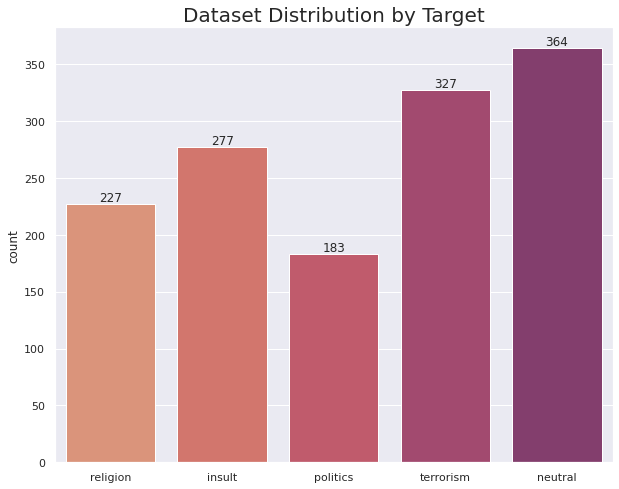

In [16]:
sns.set_theme(palette="flare")

plt.subplots(figsize=(10, 8))
ax = sns.countplot(y_train)
ax.bar_label(ax.containers[0])
plt.title('Dataset Distribution by Target', fontsize=20)
plt.show()

In [17]:
text_len = np.array([len(tweet.split(' ')) for tweet in X_train])

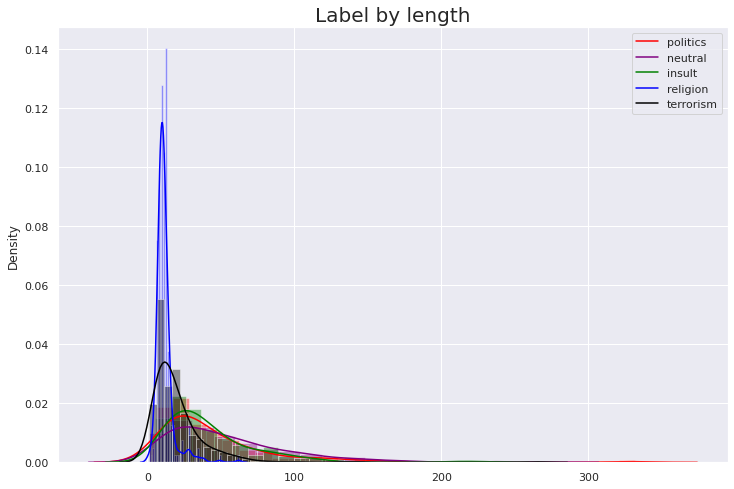

In [18]:
plt.subplots(figsize=(12,8))
sns.distplot(text_len[(y_train == 'religion')], color='r')
sns.distplot(text_len[(y_train == 'insult')], color='purple')
sns.distplot(text_len[(y_train == 'politics')], color='g')
sns.distplot(text_len[(y_train == 'terrorism')], color='blue')
sns.distplot(text_len[y_train == 'neutral'], color='black')
plt.legend(['politics', 'neutral', 'insult', 'religion', 'terrorism'])
plt.title('Label by length', fontsize=20)
plt.show()

# Text Cleaning

In [19]:
X_train

array(['Sorry for misinforming *So in summation, to be clear, since religious people report having an interest in stopping abuse and violence (and since I and many others would certainly prefer that religious people not lie and slander LGBTQ+ people as groomers and perverts and advocate that we be executed) religions and religious people should therefore stop slandering us as groomers and advocating that we be executed and instead begin trying to mitigate the untold damage and abuse on a mass scale caused by institutions they affiliate with, abuses which include thousands and thousands of actua cases of violence and grooming, which were covered up and denied and ignored for as long as possible . . . . .',
       'Excuse me kind sir/madam, what does lopsided mean She had a stroke (or 2! What part of you is tiny Probably his coc Forehead?  Nope Teeth? Nope Eyebrows? Nop Must be the brain Her future via GIPH Lma via GIPH 💀💀 Lmaoo Getting a little old to be stuffing your br Thats where she

In [20]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    text = str(text).lower()
    text = remove_emoji(text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\[', '', text)
    text = re.sub(r'\]', '', text)
    text = re.sub('â\\x92', "'", text)
    text = re.sub('â\S+', '', text)
    text = re.sub('\.+', '.', text)
    text = re.sub('&amp;', 'and', text)
    text = re.sub("let's", 'let us', text)
    text = re.sub("'s", ' is', text)
    text = re.sub("'re", ' are', text)
    text = re.sub("ain't", 'am not', text)
    text = re.sub("won't", 'will not', text)
    text = re.sub("n't", ' not', text)
    text = re.sub("'ve", ' have', text)
    text = re.sub("y'all", "you all", text)
    text = re.sub("'ll", ' will', text)
    text = re.sub("i'd", 'i would', text)
    text = re.sub("i'm", 'i am', text)
    text = re.sub(r"[^a-z<>!?\s]+", '', text)
    text = re.sub('covid\S*', 'coronavirus', text)
    text = re.sub('corona\S*', 'coronavirus', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text

In [21]:
X_train_clean = np.array([clean_text(text) for text in X_train], dtype='O')
X_val_clean = np.array([clean_text(text) for text in X_val], dtype='O')
X_test_clean = np.array([clean_text(text) for text in X_test], dtype='O')

In [22]:
X_train_clean

array(['sorry for misinforming so in summation to be clear since religious people report having an interest in stopping abuse and violence and since i and many others would certainly prefer that religious people not lie and slander lgbtq people as groomers and perverts and advocate that we be executed religions and religious people should therefore stop slandering us as groomers and advocating that we be executed and instead begin trying to mitigate the untold damage and abuse on a mass scale caused by institutions they affiliate with abuses which include thousands and thousands of actua cases of violence and grooming which were covered up and denied and ignored for as long as possible ',
       'excuse me kind sirmadam what does lopsided mean she had a stroke or ! what part of you is tiny probably his coc forehead? nope teeth? nope eyebrows? nop must be the brain her future via giph lma via giph lmaoo getting a little old to be stuffing your br thats where she keeps the rest of her fo

# Text Preprocessing

## Lemmatization and Stop Words

In [23]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
tokenizer = nltk.tokenize.TweetTokenizer()
def lemmatize(sentence):
    words = tokenizer.tokenize(sentence)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return words

In [24]:
X_train_clean = np.array([lemmatize(text) for text in tqdm(X_train_clean)], dtype='O')
print('LEMMATIZE TRAIN DONE!')
X_val_clean = np.array([lemmatize(text) for text in tqdm(X_val_clean)], dtype='O')
print('LEMMATIZE VAL DONE!')
X_test_clean = np.array([lemmatize(text) for text in tqdm(X_test_clean)], dtype='O')
print('LEMMATIZE TEST DONE!')

100%|██████████| 1378/1378 [00:09<00:00, 141.45it/s]


LEMMATIZE TRAIN DONE!


100%|██████████| 154/154 [00:00<00:00, 176.22it/s]


LEMMATIZE VAL DONE!


100%|██████████| 1019/1019 [00:04<00:00, 208.64it/s]

LEMMATIZE TEST DONE!


In [25]:
X_train_clean

array([list(['sorry', 'misinforming', 'summation', 'clear', 'since', 'religious', 'people', 'report', 'interest', 'stopping', 'abuse', 'violence', 'since', 'many', 'others', 'would', 'certainly', 'prefer', 'religious', 'people', 'lie', 'slander', 'lgbtq', 'people', 'groomers', 'pervert', 'advocate', 'executed', 'religion', 'religious', 'people', 'therefore', 'stop', 'slandering', 'u', 'groomers', 'advocating', 'executed', 'instead', 'begin', 'trying', 'mitigate', 'untold', 'damage', 'abuse', 'mass', 'scale', 'caused', 'institution', 'affiliate', 'abuse', 'include', 'thousand', 'thousand', 'actua', 'case', 'violence', 'grooming', 'covered', 'denied', 'ignored', 'long', 'possible']),
       list(['excuse', 'kind', 'sirmadam', 'lopsided', 'mean', 'stroke', '!', 'part', 'tiny', 'probably', 'coc', 'forehead', '?', 'nope', 'teeth', '?', 'nope', 'eyebrow', '?', 'nop', 'must', 'brain', 'future', 'via', 'giph', 'lma', 'via', 'giph', 'lmaoo', 'getting', 'little', 'old', 'stuffing', 'br', 'thats'

## Word Embedding GloVe

In [26]:
# open glove 840b 300d
from tqdm import tqdm
embedding_index = dict()
with open('/kaggle/input/glovetwitter27b/glove.twitter.27B.200d.txt', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors')

1193514it [01:06, 17970.29it/s]

Found 1193514 word vectors


In [27]:
max_len = max([len(sent) for sent in X_train_clean])
max_len

193

In [28]:
model_tokenizer = text.Tokenizer(filters=None, oov_token='<OOV>')
model_tokenizer.fit_on_texts(list(X_train_clean) + list(X_val_clean))
X_train_ready = sequence.pad_sequences(model_tokenizer.texts_to_sequences(X_train_clean),
                                       maxlen=max_len, padding='post')
X_val_ready = sequence.pad_sequences(model_tokenizer.texts_to_sequences(X_val_clean),
                                       maxlen=max_len, padding='post')
X_test_ready = sequence.pad_sequences(model_tokenizer.texts_to_sequences(X_test_clean),
                                       maxlen=max_len, padding='post')

word_index = model_tokenizer.word_index

In [29]:
embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in tqdm(word_index.items()):
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

100%|██████████| 7113/7113 [00:00<00:00, 165644.61it/s]


In [30]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.015537  ,  0.11158   , -0.23599   , ..., -0.037577  ,
        -0.13539   ,  0.45965001],
       ...,
       [-0.49004   , -0.25727999,  0.6498    , ...,  0.062024  ,
         0.1097    , -0.052649  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.15668   ,  0.53610998, -0.31000999, ...,  0.22171   ,
        -0.39763001, -0.2078    ]])

In [31]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
y_train_onehot = onehot.fit_transform(y_train.reshape(-1,1)).toarray()
y_val_onehot = onehot.transform(y_val.reshape(-1,1)).toarray()
y_test_onehot = onehot.transform(y_test.reshape(-1,1)).toarray()

# Modelling

## 5 Class

In [ ]:
metrics=[
        metrics.MeanSquaredError(),
        metrics.AUC(),
    ]

In [32]:
model = keras.models.Sequential([
    keras.layers.Embedding(len(word_index)+1,
                           200,
                           input_length=max_len,
                           weights=[embedding_matrix],
                           trainable=False),
    keras.layers.SpatialDropout1D(.5),
    keras.layers.Bidirectional(keras.layers.LSTM(100, recurrent_dropout=.3)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(.6),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(.6),
    
    keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=.01),
              loss='categorical_crossentropy',
              metrics='accuracy')

model.summary()

2023-02-08 22:06:38.023985: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 200)          1422800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 193, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               240800    
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              205824    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4

In [33]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                   restore_best_weights=True, verbose=1)

history = model.fit(X_train_ready, y_train_onehot, validation_data=(X_val_ready, y_val_onehot),
                    epochs=20, batch_size=512, callbacks=[es])

2023-02-08 22:06:39.161578: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
3/3 [==============================] - 24s 5s/step - loss: 2.9046 - accuracy: 0.3367 - val_loss: 1.2088 - val_accuracy: 0.5325
Epoch 2/20
3/3 [==============================] - 14s 5s/step - loss: 1.7320 - accuracy: 0.5755 - val_loss: 1.1471 - val_accuracy: 0.4481
Epoch 3/20
3/3 [==============================] - 13s 4s/step - loss: 1.1667 - accuracy: 0.6669 - val_loss: 1.0789 - val_accuracy: 0.5195
Epoch 4/20
3/3 [==============================] - 13s 4s/step - loss: 0.8428 - accuracy: 0.7373 - val_loss: 0.7391 - val_accuracy: 0.7013
Epoch 5/20
3/3 [==============================] - 14s 4s/step - loss: 0.7635 - accuracy: 0.7685 - val_loss: 0.6219 - val_accuracy: 0.7727
Epoch 6/20
3/3 [==============================] - 13s 4s/step - loss: 0.7041 - accuracy: 0.7729 - val_loss: 0.6218 - val_accuracy: 0.7403
Epoch 7/20
3/3 [==============================] - 14s 5s/step - loss: 0.7664 - accuracy: 0.7787 - val_loss: 0.6000 - val_accuracy: 0.7922
Epoch 8/20
3/3 [==================

In [38]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model.layers[0].trainable = True
model.compile(optimizer=keras.optimizers.Adam(learning_rate=.001),
              loss='categorical_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 200)          1422800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 193, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               240800    
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              205824    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4

In [39]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                   restore_best_weights=True, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1,
                                              factor=.1)

history = model.fit(X_train_ready, y_train_onehot, validation_data=(X_val_ready, y_val_onehot),
                    epochs=80, batch_size=512, callbacks=[es, reduce_lr])

Epoch 1/80
3/3 [==============================] - 25s 5s/step - loss: 0.3542 - acc: 0.9049 - f1_m: 0.9040 - precision_m: 0.9103 - recall_m: 0.8978 - val_loss: 0.4490 - val_acc: 0.8247 - val_f1_m: 0.8344 - val_precision_m: 0.8514 - val_recall_m: 0.8182
Epoch 2/80
3/3 [==============================] - 14s 5s/step - loss: 0.3347 - acc: 0.9020 - f1_m: 0.9042 - precision_m: 0.9075 - recall_m: 0.9009 - val_loss: 0.4726 - val_acc: 0.8377 - val_f1_m: 0.8533 - val_precision_m: 0.8767 - val_recall_m: 0.8312
Epoch 3/80
3/3 [==============================] - 15s 5s/step - loss: 0.2439 - acc: 0.9180 - f1_m: 0.9196 - precision_m: 0.9250 - recall_m: 0.9143 - val_loss: 0.4605 - val_acc: 0.8312 - val_f1_m: 0.8477 - val_precision_m: 0.8649 - val_recall_m: 0.8312
Epoch 4/80
3/3 [==============================] - 14s 5s/step - loss: 0.3104 - acc: 0.9180 - f1_m: 0.9171 - precision_m: 0.9220 - recall_m: 0.9122 - val_loss: 0.4486 - val_acc: 0.8377 - val_f1_m: 0.8562 - val_precision_m: 0.8828 - val_recall_m:

In [36]:
# loss, acc = model.evaluate(X_test_ready, y_test_onehot)
# print(f'Test set Accuracy {acc:.3f}')

In [37]:
score = model.evaluate(X_test_ready, y_test_onehot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0298925638198853
Test accuracy: 0.7114818692207336


In [44]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test_ready, y_test_onehot, verbose=0)

In [45]:
loss, accuracy, f1_score, precision, recall

(1.1708635091781616,
 0.707556426525116,
 0.6944592595100403,
 0.709829568862915,
 0.6808449029922485)